In [17]:
import glob
import os
import scipy
import torch
import numpy as np
import flow_transforms
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.nn.functional import grid_sample
from imageio import imread

def load_flo(path):
    with open(path, 'rb') as f:
        magic = np.fromfile(f, np.float32, count=1)
        assert(202021.25 == magic),'Magic number incorrect. Invalid .flo file'
        h = np.fromfile(f, np.int32, count=1)[0]
        w = np.fromfile(f, np.int32, count=1)[0]
        data = np.fromfile(f, np.float32, count=2*w*h)
    # Reshape data into 3D array (columns, rows, bands)
    data2D = np.resize(data, (w, h, 2))
    return data2D

def default_loader(root, path_imgs, path_flo, path_occ):
    imgs = [os.path.join(root,path) for path in path_imgs]
    flo = os.path.join(root,path_flo)
    occ = os.path.join(root,path_occ)
    return [imread(img).astype(np.float32) for img in imgs], load_flo(flo), imread(occ)

In [18]:
images = []
root = 'sintel'
scene_dir = 'ambush_7'
#scene_dir = 'sleeping_1'
for flow_map in sorted(glob.glob(os.path.join('sintel','flow',scene_dir,'*.flo'))):
    flow_map = os.path.relpath(flow_map, os.path.join('sintel','flow'))
    
    scene_dir, filename = os.path.split(flow_map)
    no_ext_filename = os.path.splitext(filename)[0]
    prefix, frame_nb = no_ext_filename.split('_')
    frame_nb = int(frame_nb)
    
    img1 = os.path.join('clean', scene_dir, '{}_{:04d}.png'.format(prefix, frame_nb))
    img2 = os.path.join('clean', scene_dir, '{}_{:04d}.png'.format(prefix, frame_nb+1))
    occ_mask = os.path.join('occlusions', scene_dir, '{}_{:04d}.png'.format(prefix, frame_nb))
    flow_map = os.path.join('flow', flow_map)
    
    if not (os.path.isfile(os.path.join('sintel',img1)) and os.path.isfile(os.path.join('sintel',img2))):
        continue
    images.append([[img1,img2], flow_map, occ_mask])

split_factor = 1.1     ## ratio of train split
split_values = np.random.uniform(0,1,len(images)) < split_factor
train_samples = [sample for sample, split in zip(images, split_values) if split]
test_samples = [sample for sample, split in zip(images, split_values) if not split]

In [19]:
## Sampled frames
start_frame = 25
end_frame = 41

inputs, target, mask = train_samples[start_frame]
inputs, target, mask = default_loader(root, inputs, target, mask)
height, width, _ = target.shape

## Grid Location Point (x,y) matrix of size H X W
Y, X = torch.meshgrid(torch.arange(0, height), torch.arange(0, width))
Grid = torch.stack((X, Y), 2).float()
## Survived points in start frame image.  H x W
non_occ_mask = torch.ones(height, width)    

## new_Grid as transformed pixel location, according to each pixel location in source frame
new_Grid = Grid.clone()
new_Grid_norm = torch.zeros(Grid.size()).unsqueeze(0)

for ind in range(start_frame, end_frame):
    imgs, target, occ_mask = train_samples[ind]
    target = torch.from_numpy(load_flo(os.path.join(root, target)))   ## Flow annotation. H x W x 2
    occ_mask = torch.from_numpy(imread(os.path.join(root, occ_mask))).float() / 255    ## Occlusion mask. H x W
    
    if ind == start_frame:
        warped_flow = target.permute(2,0,1)
        warped_occ_mask = occ_mask
    else:
        ## Warping Occlusion Mask
        warped_flow     = grid_sample(target.permute(2,0,1).unsqueeze(0),
                              new_Grid_norm, mode='nearest',
                              align_corners=True)[0]
        ## Warping Flow information
        warped_occ_mask = grid_sample(occ_mask[(None,)*2 + (...,)], 
                              new_Grid_norm, mode='nearest', 
                              align_corners=True)[0][0]

    non_occ_mask = non_occ_mask * (1 - warped_occ_mask)
    
    new_Grid[:,:,0] = torch.clamp((new_Grid[:,:,0] + warped_flow[0,:,:]), 0, width-1)
    new_Grid[:,:,1] = torch.clamp((new_Grid[:,:,1] + warped_flow[1,:,:]), 0, height-1)
    
    new_Grid_norm[:,:,:,0] = 2.0*new_Grid[:,:,0].clone() / max(width-1,1)-1.0       
    new_Grid_norm[:,:,:,1] = 2.0*new_Grid[:,:,1].clone() / max(height-1,1)-1.0
    
outputs, target, occ_mask = train_samples[end_frame]    
outputs, _, _ = default_loader(root, outputs, target, occ_mask)

source_grid = (non_occ_mask == 1).nonzero().transpose(0,1)
source_points = Grid[source_grid[0], source_grid[1]].long().transpose(0,1)
target_points = new_Grid[source_grid[0], source_grid[1]].long().transpose(0,1)
print(source_points.size())

torch.Size([2, 229180])


In [20]:
#########################################################
#################   Visualize Warpings   ################
#########################################################

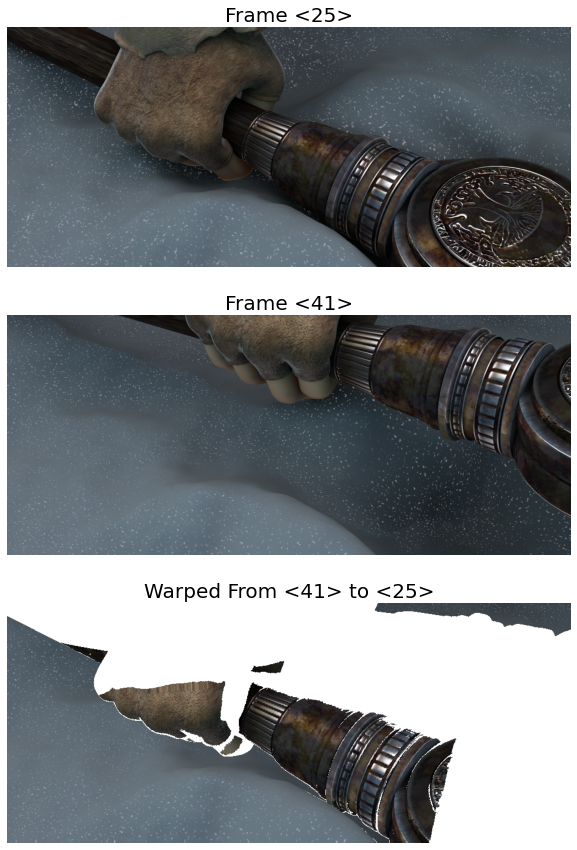

In [21]:
## Warping Flow & Visualize
src = inputs[0]
tar = outputs[0]
src = torch.from_numpy(src).permute(2,0,1).unsqueeze(0)
tar = torch.from_numpy(tar).permute(2,0,1).unsqueeze(0)
occ_mask = 1 - non_occ_mask
warped_img = grid_sample(tar, new_Grid_norm, mode='nearest', align_corners=True)
warped_img = warped_img * non_occ_mask + 255 * occ_mask
#src = src * source_grid + 255 * (1 - source_grid)

fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(3,1,1)
ax1.set_title('Frame <%d>'% start_frame, fontsize=20)
ax1.axis("off")
ax1.imshow(src[0].permute(1,2,0).numpy()/255)
ax2 = fig.add_subplot(3,1,2)
ax2.set_title('Frame <%d>'% end_frame, fontsize=20)
ax2.axis("off")
ax2.imshow(tar[0].permute(1,2,0).numpy()/255)
ax3 = fig.add_subplot(3,1,3)
ax3.set_title('Warped From <%d> to <%d>'% (end_frame, start_frame), fontsize=20)
ax3.axis("off")
ax3.imshow(warped_img[0].permute(1,2,0).numpy()/255)

In [22]:
#########################################################
#################   Visualize Matches   #################
#########################################################

In [23]:
#from utils import build_composite_image

#img1 = os.path.join(root, train_samples[start_frame][0][0])
#img2 = os.path.join(root, train_samples[end_frame][0][0])

#im, v_offset, h_offset = build_composite_image(img1, img2, margin=5, axis=0)

#plt.figure(figsize=(10,10))
#plt.imshow(im)

#_, target, mask = train_samples[start_frame]
#target = torch.from_numpy(load_flo(os.path.join(root, target)))

#linewidth = 0.5
#for idx in range(0, int(source_points.size(1)), 10000):
#    #print(source_points[:,idx], target_points[:,idx], target[source_points[0,idx],source_points[1,idx],:])
#    plt.plot((source_points[0,idx] + h_offset[0], target_points[0,idx] + h_offset[1]),
#             (source_points[1,idx] + v_offset[0], target_points[1,idx] + v_offset[1]),
#             color='r',
#             linewidth=linewidth)

        
#plt.tight_layout()
##plt.axis('off')

In [24]:
#########################################################
############   Visualize Flow Distribution   ############
#########################################################

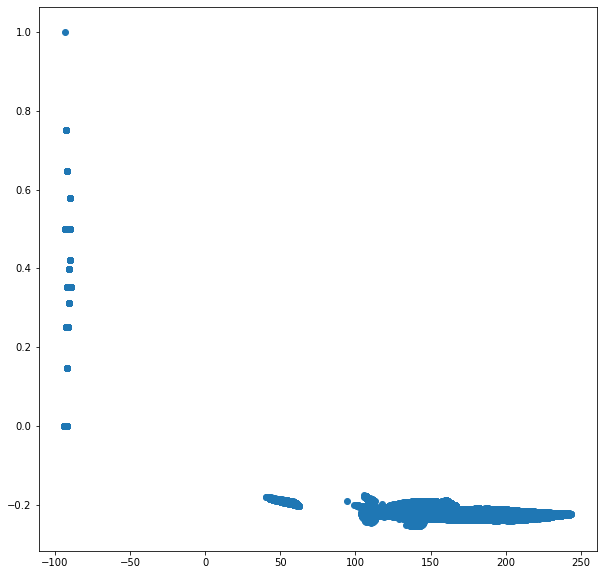

In [25]:
import math

Flows = (target_points - source_points).float()
magnitude   = Flows.norm(p=2, dim=0)
magnitude   = magnitude - magnitude.mean()
#magnitude   = magnitude.pow(2)
orientation = torch.atan2(Flows[1], Flows[0]) / math.pi

plt.figure(figsize=(10,10))
plt.scatter(magnitude.numpy(), orientation.numpy())

80087 tensor([[ 98,  99, 100,  ..., 764, 765, 766],
        [ 72,  72,  73,  ..., 435, 435, 435]])
34.94502138057422


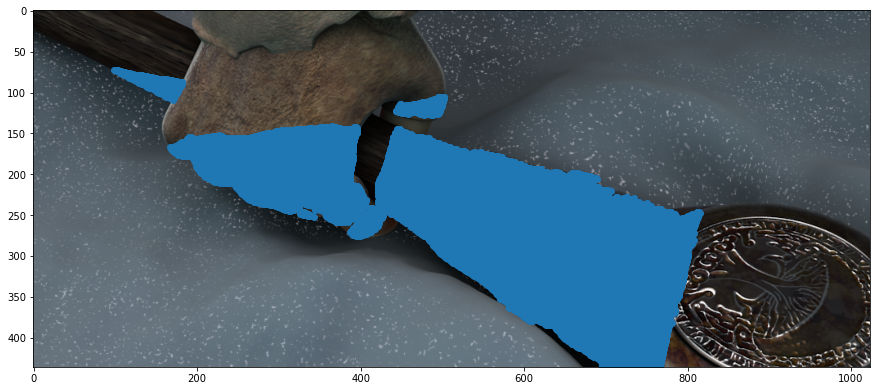

In [26]:
#Id = [idx for idx, mag in enumerate(magnitude.tolist()) if mag > 50] # and mag < 40]
#Id = [idx for idx, ori in enumerate(orientation.tolist()) if ori > 0.5]# and ori < 0.51]
Id = [idx for idx, (mag, ori) in enumerate(zip(magnitude.tolist(), orientation.tolist())) \
              if mag > 20]
sampled_outliers = source_points[:,Id]
print(len(Id),sampled_outliers)
print(len(Id) / source_points.size(1) * 100)

import matplotlib.image as mpimg
img = os.path.join(root, train_samples[start_frame][0][0])
im = mpimg.imread(img)

plt.figure(figsize=(15,15))
plt.imshow(im)

plt.scatter(sampled_outliers[0].numpy(), sampled_outliers[1].numpy())

In [ ]:
import math
flow_map = new_Grid - Grid
window_w, window_h = (15, 15)



Flows = (target_points - source_points).float()
magnitude   = Flows.norm(p=2, dim=0)
magnitude   = magnitude - magnitude.mean()
#magnitude   = magnitude.pow(2)
orientation = torch.atan2(Flows[1], Flows[0]) / math.pi

plt.figure(figsize=(10,10))
plt.scatter(magnitude.numpy(), orientation.numpy())

In [ ]:
#########################################################
################   Image Preprocessing   ################
#########################################################

In [ ]:
####### Data Pre-processing #######

input_transform = transforms.Compose([
    flow_transforms.ArrayToTensor(),
    transforms.Normalize(mean=[0,0,0], std=[255,255,255]),
    transforms.Normalize(mean=[0.45,0.432,0.411], std=[1,1,1])
])
target_transform = transforms.Compose([
    flow_transforms.ArrayToTensor(),
    transforms.Normalize(mean=[0,0],std=[20,20])
])
## sparse ##
co_transform = flow_transforms.Compose([
    flow_transforms.RandomCrop((320,448)),
    flow_transforms.RandomVerticalFlip(),
    flow_transforms.RandomHorizontalFlip()
])

print(inputs[0].shape, target.shape)   ### Compare before & after data pre-processing ###
if co_transform is not None:
    inputs, target = co_transform(inputs, target)
if input_transform is not None:
    inputs[0] = input_transform(inputs[0])
    inputs[1] = input_transform(inputs[1])
if target_transform is not None:
    target = target_transform(target)

#print(inputs[0][0,100:107,100:107])
#print(target[0].max(), target[1].max())
#print(inputs[0].size(), target.size())